## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [23]:
EXPERIMENT_NAME="Basic"
assert(not EXPERIMENT_NAME is None)

import tensorflow as tf
import uuid
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import math
import warnings
import rasterio
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


%matplotlib inline
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
PROJECT_PATH = "/workspace/COMPUTERVISIONPROYECT"

# XVIEW_RECOGNITION_PATH = "./data/xview_recognition/"
XVIEW_RECOGNITION_PATH = os.path.join(PROJECT_PATH, "data/xview_recognition")

EXPERIMENT_PATH = os.path.join(PROJECT_PATH, "experiment_results", EXPERIMENT_NAME)
if not os.path.exists(EXPERIMENT_PATH):
    os.mkdir(EXPERIMENT_PATH)

## Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
WEIGHT_DECAY = None
DROPOUT_RATE = None
REGULARIZER_PENALTY = None
EPOCHS = 20

categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

# Required classes and functions

In [28]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [29]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

# 0. La usamos para las imágenes de test
def load_geoimage(filename_tensor):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    filename = filename_tensor
    src_raster = rasterio.open(filename, 'r')

    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

# 1. Función para decodificar los ejemplos del archivo
def _parse_image_function(example_proto):
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'category_id': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    
    features = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.decode_raw(features['image_raw'], out_type=tf.uint8)
    shape = [features['height'], features['width'], features['depth']]
    image = tf.reshape(image, shape)
    image = tf.cast(image, tf.float32)
    
    image = tf.image.resize(image, [224, 224])
    
    category_id = tf.cast(features['category_id'], tf.int32)
    label = tf.one_hot(category_id, depth=len(categories))
    
    return image, label

# 2. Función para crear el dataset
def create_tfrecord_dataset(filenames, batch_size, do_shuffle=False):
    # Lee los archivos TFRecord. Puede leer de múltiples archivos en paralelo.
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    
    if do_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [5]:
train_dataset = create_tfrecord_dataset([os.path.join(XVIEW_RECOGNITION_PATH, 'train.tfrecord')], BATCH_SIZE, do_shuffle=True)
valid_dataset = create_tfrecord_dataset([os.path.join(XVIEW_RECOGNITION_PATH, 'validation.tfrecord')], BATCH_SIZE)

I0000 00:00:1759994218.381435   48693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759994218.381477   48693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759994218.381484   48693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759994218.530804   48693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759994218.530838   48693 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-09

In [6]:
print('Load model')

model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Dense(len(categories)))
model.add(Activation('softmax'))
model.summary()

Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 activation (Activation)     (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 13)                1956877   
                                                                 
 activation_1 (Activation)   (None, 13)                0         
                                                                 
Total params: 1956877 (7.46 MB)
Trainable params: 1956877 (7.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
opt = Adam(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping('val_loss', patience=10, verbose=1, restore_best_weights=True)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [9]:
print('Training model')
h = model.fit(train_dataset, 
              validation_data=valid_dataset, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model (using validation loss)
best_idx = int(np.argmin(h.history['val_loss']))
best_values = h.history['val_accuracy'][best_idx], h.history['val_loss'][best_idx]
print(
    f'''--------\n
    Best validation model
    - epoch: {str(best_idx + 1)}
    - val_acc: {str(best_values[0])}
    - val_loss: {str(best_values[1])}'''
)

Training model
Epoch 1/20


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
I0000 00:00:1759994225.188665   48848 service.cc:146] XLA service 0x7f8698fad830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759994225.188693   48848 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 5070 Ti, Compute Capability 12.0
2025-10-09 07:17:05.198954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


      8/Unknown - 2s 8ms/step - loss: 8871.5527 - accuracy: 0.1797  

2025-10-09 07:17:05.564556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
I0000 00:00:1759994225.630545   48848 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


   1051/Unknown - 11s 9ms/step - loss: 3475.8494 - accuracy: 0.2619

2025-10-09 07:17:15.071074: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-09 07:17:15.071162: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[sequential/flatten/Shape/_4]]
2025-10-09 07:17:15.071203: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15204650635028992521
2025-10-09 07:17:15.071210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1828397521244422829
2025-10-09 07:17:15.071215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4153888064960094918
2025-10-09 07:17:15.071235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16718093328066360768



Epoch 1: val_loss improved from inf to 3871.09058, saving model to model.keras


2025-10-09 07:17:16.355125: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[sequential/flatten/Shape/_4]]
2025-10-09 07:17:16.374715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15204650635028992521
2025-10-09 07:17:16.374740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1828397521244422829
2025-10-09 07:17:16.374751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4153888064960094918
2025-10-09 07:17:16.374773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16718093328066360768


1055/1055 [==============================] - 13s 10ms/step - loss: 3473.9653 - accuracy: 0.2615 - val_loss: 3871.0906 - val_accuracy: 0.3291 - lr: 0.0010
Epoch 2/20
1049/1055 [============================>.] - ETA: 0s - loss: 3485.3335 - accuracy: 0.2989
Epoch 2: val_loss improved from 3871.09058 to 3406.31885, saving model to model.keras
1055/1055 [==============================] - 5s 5ms/step - loss: 3484.9055 - accuracy: 0.2987 - val_loss: 3406.3188 - val_accuracy: 0.3435 - lr: 0.0010
Epoch 3/20
1047/1055 [============================>.] - ETA: 0s - loss: 3525.2581 - accuracy: 0.3151
Epoch 3: val_loss improved from 3406.31885 to 3083.86157, saving model to model.keras
1055/1055 [==============================] - 4s 4ms/step - loss: 3524.5906 - accuracy: 0.3144 - val_loss: 3083.8616 - val_accuracy: 0.3344 - lr: 0.0010
Epoch 4/20
1054/1055 [============================>.] - ETA: 0s - loss: 3378.2249 - accuracy: 0.3293
Epoch 4: val_loss improved from 3083.86157 to 2872.71411, saving mo

# Validation
Compute validation metrics.

In [1]:
valid_dataset = create_tfrecord_dataset([os.path.join(XVIEW_RECOGNITION_PATH, 'validation.tfrecord')], BATCH_SIZE)
predictions = model.predict(valid_dataset)
category_names = np.array(list(categories.values()))
y_pred = category_names[predictions.argmax(axis=1)]

y_true = []

for images_batch, labels_batch in valid_dataset:
    labels_np = labels_batch.numpy()
    
    true_indices = np.argmax(labels_np, axis=1)
    batch_labels = category_names[true_indices]
    
    y_true.extend(batch_labels)

NameError: name 'create_tfrecord_dataset' is not defined

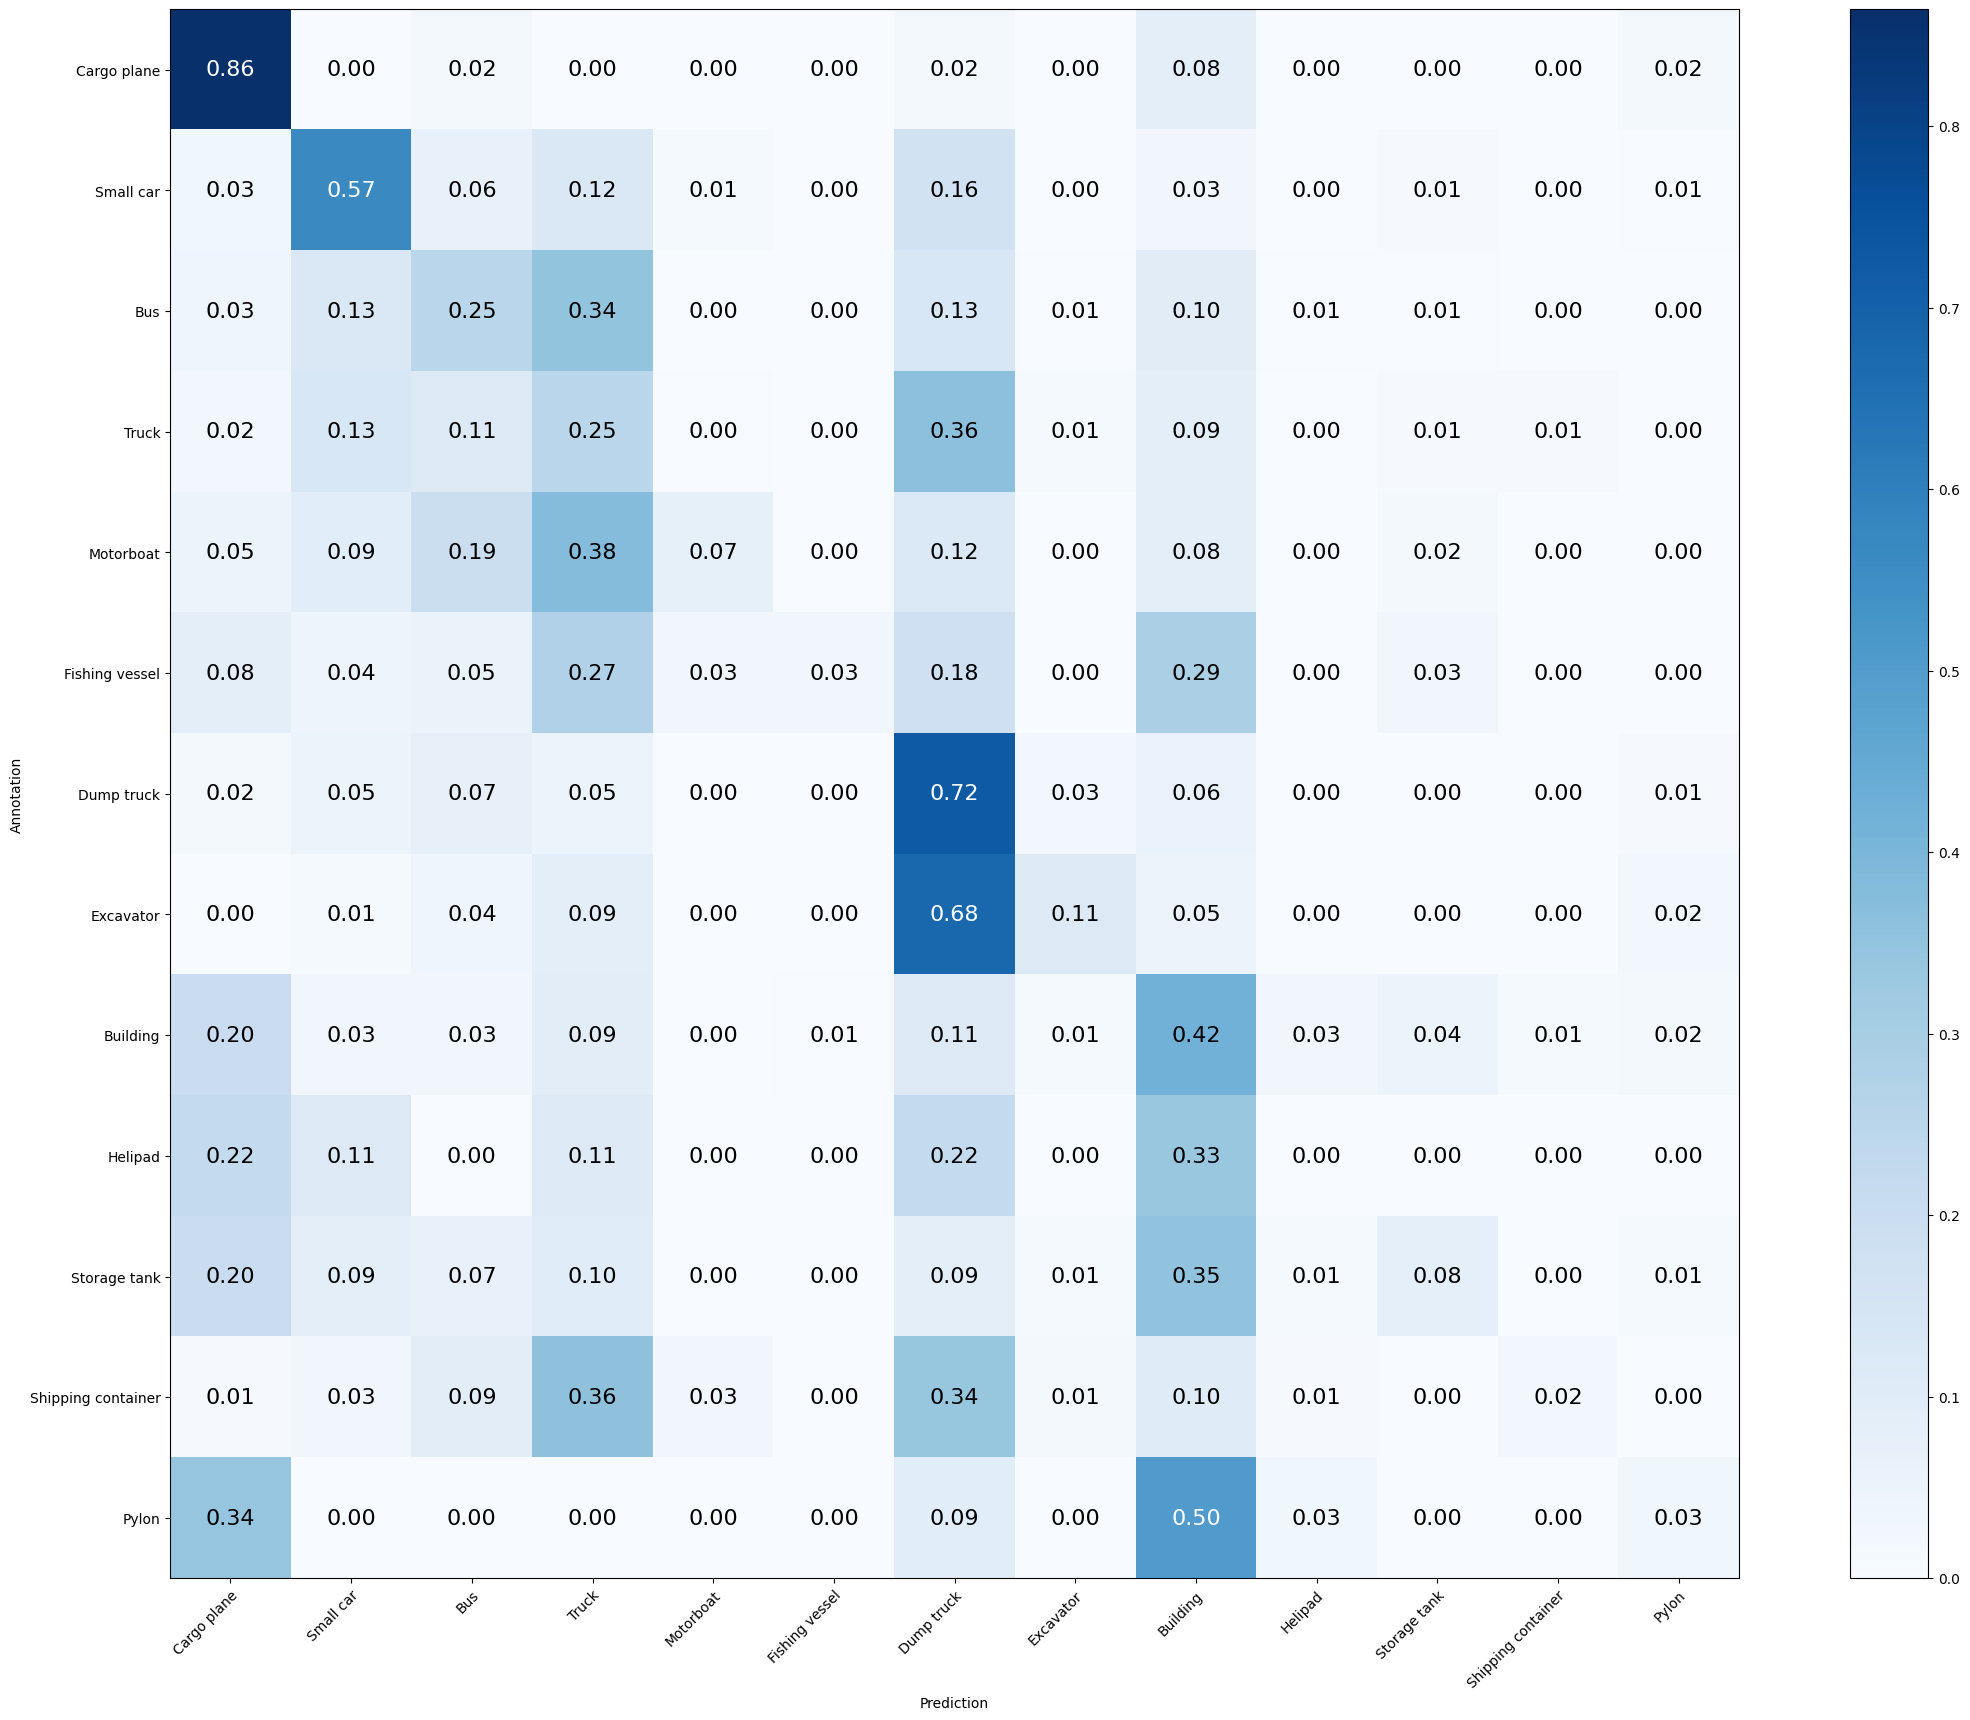

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [12]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 32.587%
Mean Recall: 26.204%
Mean Precision: 30.669%
> Cargo plane: Recall: 86.441% Precision: 25.248% Specificity: 91.685% Dice: 39.080%
> Small car: Recall: 56.535% Precision: 64.583% Specificity: 93.402% Dice: 60.292%
> Bus: Recall: 24.713% Precision: 26.875% Specificity: 93.122% Dice: 25.749%
> Truck: Recall: 24.896% Precision: 18.072% Specificity: 83.354% Dice: 20.942%
> Motorboat: Recall: 7.339% Precision: 40.000% Specificity: 99.320% Dice: 12.403%
> Fishing vessel: Recall: 2.740% Precision: 50.000% Specificity: 99.889% Dice: 5.195%
> Dump truck: Recall: 72.034% Precision: 19.495% Specificity: 80.023% Dice: 30.686%
> Excavator: Recall: 11.111% Precision: 37.500% Specificity: 99.164% Dice: 17.143%
> Building: Recall: 41.598% Precision: 45.758% Specificity: 88.161% Dice: 43.579%
> Helipad: Recall: 0.000% Precision: 0.000% Specificity: 99.143% Dice: 0.000%
> Storage tank: Recall: 7.895% Precision: 31.579% Specificity: 98.491% Dice: 12.632%
> Shipping container: Recall

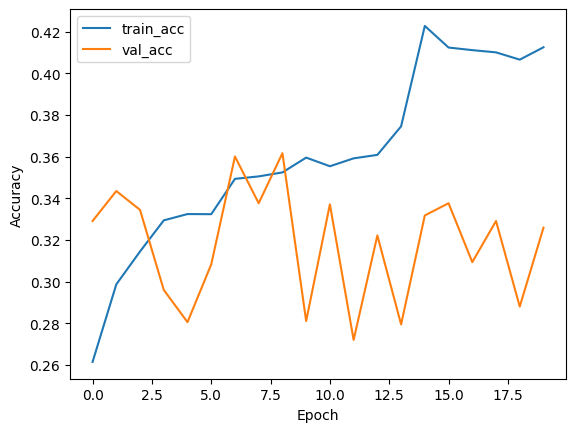

In [13]:
plt.plot(h.history['accuracy'], label='train_acc')
plt.plot(h.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

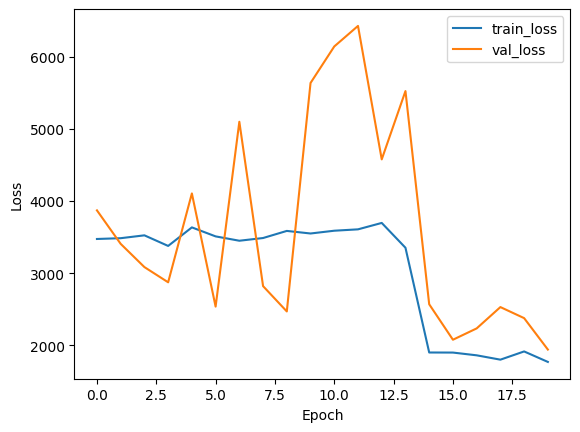

In [14]:
plt.plot(h.history['loss'], label='train_loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing
Try to improve the results provided in the competition.

In [20]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(XVIEW_RECOGNITION_PATH, 'xview_recognition/xview_test')):
    for filename in filenames:
        image = GenericImage(os.path.join(dirpath,filename))
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 0


In [24]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [26]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)